In [1]:
import pickle
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from IPython.display import display_latex

from adsorption_model import Experiment

# Partial functions
display_latex = partial(display_latex, raw=True)
root_scalar = partial(root_scalar, method="bisect")

# Scaling (finding $x$)

$$
\begin{equation}
    \dfrac{\mathsf{EBCT}_\mathsf{RSSCT}}{\mathsf{EBCT}_\mathsf{Pilot}}
    =
    \left[
        \dfrac{d_{p \, \mathsf{RSSCT}}}{d_{p \, \mathsf{Pilot}}}
    \right]^{2-x}
\end{equation}
$$

Solving for $x$

$$
\begin{equation*}
    \ln{\left(\tfrac{\mathsf{EBCT}_\mathsf{RSSCT}}{\mathsf{EBCT}_\mathsf{Pilot}}\right)}
    =
    \left( 2 - x \right)
    \ln{\left(\tfrac{d_{p \, \mathsf{RSSCT}}}{d_{p \, \mathsf{Pilot}}}\right)}
\end{equation*}
$$

$$
\begin{equation*}
    \left( 2 - x \right)
    =
    \frac{\ln{\left(\tfrac{\mathsf{EBCT}_\mathsf{RSSCT}}{\mathsf{EBCT}_\mathsf{Pilot}}\right)}}
    {\ln{\left(\tfrac{d_{p \, \mathsf{RSSCT}}}{d_{p \, \mathsf{Pilot}}}\right)}}
\end{equation*}
$$

$$
\begin{equation*}
    x
    =
    2 -
    \frac{\ln{\left(\tfrac{\mathsf{EBCT}_\mathsf{RSSCT}}{\mathsf{EBCT}_\mathsf{Pilot}}\right)}}
    {\ln{\left(\tfrac{d_{p \, \mathsf{RSSCT}}}{d_{p \, \mathsf{Pilot}}}\right)}}
\end{equation*}
$$

In [2]:
def find_t50(t: float, experiment: Experiment):
    """Helper to find time at which C/C0 = 0.5"""
    return 0.50 - experiment.callable(t)

In [3]:
with open(".data/experiments.pkl", "rb") as f:
    data = pickle.load(f)

## Comparing RSSCT and Pilot (4 min)

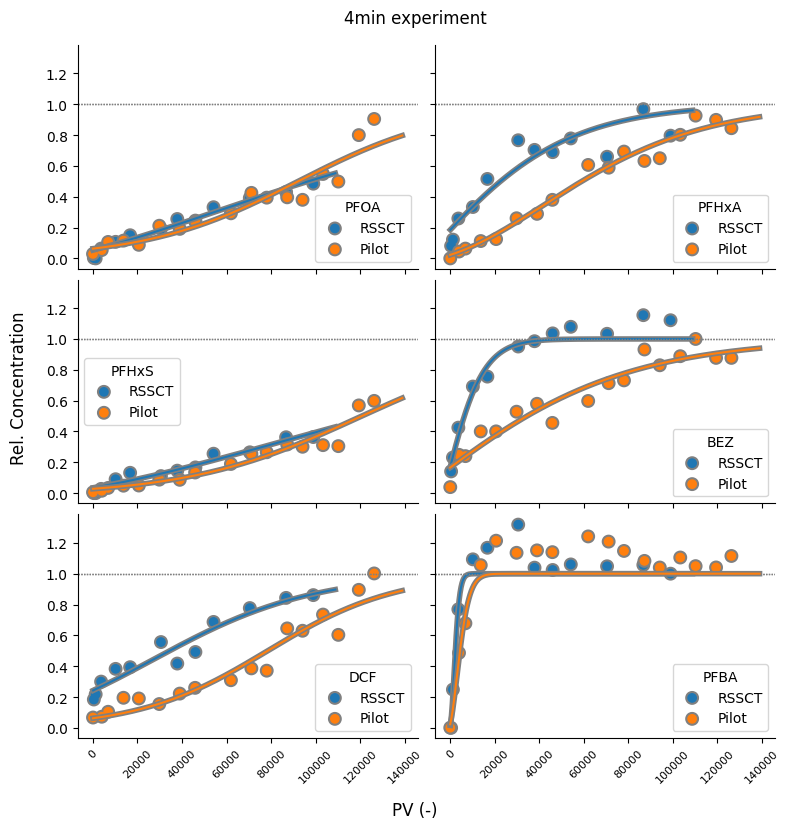

In [4]:
smalls = data["SMALL 4min"]
pilots = data["PILOT 4min"]

fig, axs = plt.subplots(
    3,
    2,
    figsize=(9, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0.05, "wspace": 0.05},
)

for ax, small, pilot in zip(axs.flatten(), smalls, pilots):
    small.plot_relative_btc_in_porevols(ax=ax, with_fit=True)
    pilot.plot_relative_btc_in_porevols(ax=ax, with_fit=True)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    hands, legs = ax.get_legend_handles_labels()
    ax.legend(hands[::2], ["RSSCT", "Pilot"], title=small.contaminant)
    ax.tick_params(axis="x", labelrotation=45, labelsize=8)

fig.suptitle("4min experiment", y=0.92)
fig.supxlabel("PV (-)", y=0.02)
fig.supylabel("Rel. Concentration", x=0.05)
plt.show()

#### Calculate theoretical and experiment `x` scaling factor

In [5]:
for i, (small, pilot) in enumerate(zip(smalls, pilots)):
    small: Experiment
    pilot: Experiment

    if i == 0:
        print("                   RSSCT    Pilot")
        print(
            "Pore volume (s)",
            f"{small.pv * 3600:8.1f}",
            f"{pilot.pv * 3600:8.1f}",
        )
        print(
            "Reynolds Number",
            f"{small.reynolds:8.3f}",
            f"{pilot.reynolds:8.3f}",
        )

        dp_factor = small.setup.particle_size / pilot.setup.particle_size
        print(f"Scaling factor dp (rssct/pilot): {dp_factor}")

        pv_factor = small.pv / pilot.pv
        print(f"Scaling factor EBCT (rssct/pilot): {pv_factor:.3f}")

        x = 2 - np.log(pv_factor) / np.log(dp_factor)
        print(f"Solving for x: {x:.3f} <-- Theoretical")

    assert small.contaminant == pilot.contaminant
    contaminant = small.contaminant
    print(f"\n {contaminant}")

    small_50 = root_scalar(find_t50, args=(small,), bracket=[1, 1_000])
    pilot_50 = root_scalar(find_t50, args=(pilot,), bracket=[1, 10_000])

    if small_50.converged and pilot_50.converged:
        timescale = small_50.root / pilot_50.root
        print(f"Contact time scale rssct/pilot: {timescale:.3f}")

        dp_factor = small.setup.particle_size / pilot.setup.particle_size
        print(f"Particle size scale rssct/pilot: {dp_factor:.3f}")

        x = 2 - np.log(timescale) / np.log(dp_factor)
        print(f"Solving for x: {x:.3f} <-- Experimental")

                   RSSCT    Pilot
Pore volume (s)      4.4     37.6
Reynolds Number    0.323    0.355
Scaling factor dp (rssct/pilot): 0.32
Scaling factor EBCT (rssct/pilot): 0.118
Solving for x: 0.121 <-- Theoretical

 PFOA
Contact time scale rssct/pilot: 0.123
Particle size scale rssct/pilot: 0.320
Solving for x: 0.163 <-- Experimental

 PFHxA
Contact time scale rssct/pilot: 0.045
Particle size scale rssct/pilot: 0.320
Solving for x: -0.723 <-- Experimental

 PFHxS
Contact time scale rssct/pilot: 0.124
Particle size scale rssct/pilot: 0.320
Solving for x: 0.167 <-- Experimental

 BEZ
Contact time scale rssct/pilot: 0.022
Particle size scale rssct/pilot: 0.320
Solving for x: -1.363 <-- Experimental

 DCF
Contact time scale rssct/pilot: 0.052
Particle size scale rssct/pilot: 0.320
Solving for x: -0.602 <-- Experimental

 PFBA
Contact time scale rssct/pilot: 0.062
Particle size scale rssct/pilot: 0.320
Solving for x: -0.447 <-- Experimental


## Comparing RSSCT and Pilot (6 min)

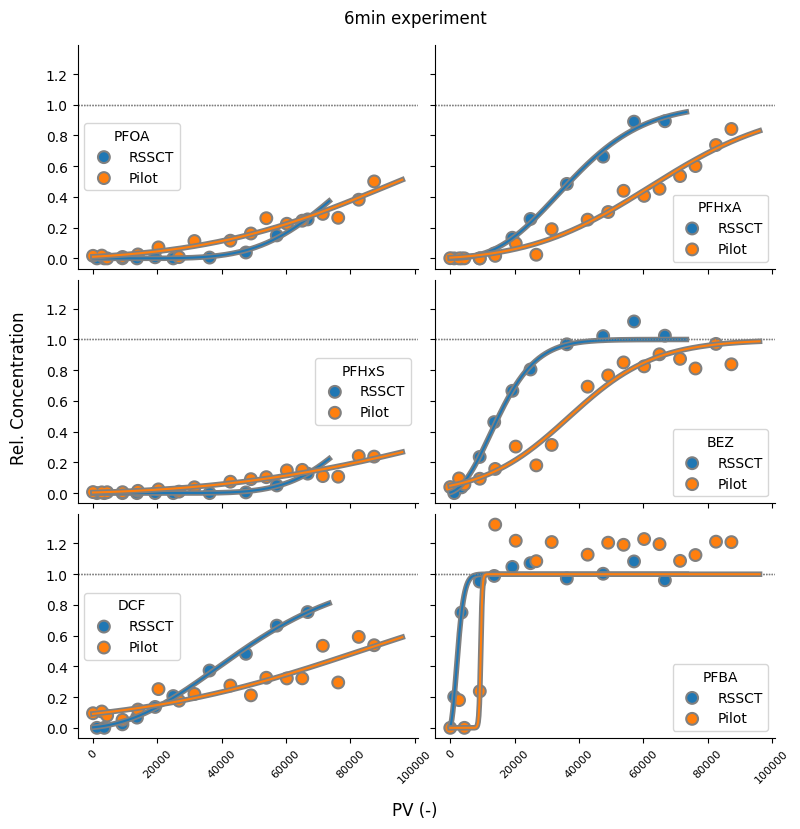

In [6]:
smalls = data["SMALL 6min"]
pilots = data["PILOT 6min"]

fig, axs = plt.subplots(
    3,
    2,
    figsize=(9, 9),
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0.05, "wspace": 0.05},
)

for ax, small, pilot in zip(axs.flatten(), smalls, pilots):
    small.plot_relative_btc_in_porevols(ax=ax, with_fit=True)
    pilot.plot_relative_btc_in_porevols(ax=ax, with_fit=True)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    hands, legs = ax.get_legend_handles_labels()
    ax.legend(hands[::2], ["RSSCT", "Pilot"], title=small.contaminant)
    ax.tick_params(axis="x", labelrotation=45, labelsize=8)

fig.suptitle("6min experiment", y=0.92)
fig.supxlabel("PV (-)", y=0.02)
fig.supylabel("Rel. Concentration", x=0.05)
plt.show()

In [7]:
for i, (small, pilot) in enumerate(zip(smalls, pilots)):
    small: Experiment
    pilot: Experiment

    if i == 0:
        print("                   RSSCT    Pilot")
        print(
            "Pore volume (s)",
            f"{small.pv * 3600:8.1f}",
            f"{pilot.pv * 3600:8.1f}",
        )
        print(
            "Reynolds Number",
            f"{small.reynolds:8.3f}",
            f"{pilot.reynolds:8.3f}",
        )

        dp_factor = small.setup.particle_size / pilot.setup.particle_size
        print(f"Scaling factor dp (rssct/pilot): {dp_factor}")

        pv_factor = small.pv / pilot.pv
        print(f"Scaling factor EBCT (rssct/pilot): {pv_factor:.3f}")

        x = 2 - np.log(pv_factor) / np.log(dp_factor)
        print(f"Solving for x: {x:.3f} <-- Theoretical")

    assert small.contaminant == pilot.contaminant
    contaminant = small.contaminant

    print(f"\n {contaminant}")
    small_50 = root_scalar(find_t50, args=(small,), bracket=[1, 1_000])
    pilot_50 = root_scalar(find_t50, args=(pilot,), bracket=[1, 10_000])

    if small_50.converged and pilot_50.converged:
        timescale = small_50.root / pilot_50.root
        print(f"Contact time scale rssct/pilot: {timescale:.3f}")

        dp_factor = small.setup.particle_size / pilot.setup.particle_size
        print(f"Particle size scale rssct/pilot: {dp_factor:.3f}")

        x = 2 - np.log(timescale) / np.log(dp_factor)
        print(f"Solving for x: {x:.3f} <-- Experimental")

                   RSSCT    Pilot
Pore volume (s)      6.4     54.1
Reynolds Number    0.337    0.370
Scaling factor dp (rssct/pilot): 0.32
Scaling factor EBCT (rssct/pilot): 0.118
Solving for x: 0.123 <-- Theoretical

 PFOA
Contact time scale rssct/pilot: 0.100
Particle size scale rssct/pilot: 0.320
Solving for x: -0.021 <-- Experimental

 PFHxA
Contact time scale rssct/pilot: 0.068
Particle size scale rssct/pilot: 0.320
Solving for x: -0.362 <-- Experimental

 PFHxS
Contact time scale rssct/pilot: 0.075
Particle size scale rssct/pilot: 0.320
Solving for x: -0.279 <-- Experimental

 BEZ
Contact time scale rssct/pilot: 0.048
Particle size scale rssct/pilot: 0.320
Solving for x: -0.669 <-- Experimental

 DCF
Contact time scale rssct/pilot: 0.065
Particle size scale rssct/pilot: 0.320
Solving for x: -0.393 <-- Experimental

 PFBA
Contact time scale rssct/pilot: 0.030
Particle size scale rssct/pilot: 0.320
Solving for x: -1.092 <-- Experimental


### Numbers

Reynolds number

$$
\begin{equation}
    R_e = \dfrac{d_p \, u}{\nu}
\end{equation}
$$

Pore Volume (EBCT)
$$
\begin{equation}
    \mathtt{PV} = \dfrac{L}{u} = \dfrac{L}{q/n}
\end{equation}
$$